# Lab Assignment Five: Wide and Deep Network Architectures
 

#### Everett Cienkus, Blake Miller, Colin Weil

### 1. Preparation

#### 1.1 Define and Prepare Class Variables

Data from https://www.kaggle.com/datasets/arashnic/hr-ana

Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Load the data into memory and save it to a pandas data frame.
df = pd.read_csv('promotion_dataset/train.csv')
df = df.dropna()

df_train, df_test = train_test_split(df,train_size=0.8)
df_test

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
44213,30508,Technology,region_2,Bachelor's,f,other,2,46,1.0,2,0,82,0
16717,77643,HR,region_2,Bachelor's,m,other,1,46,3.0,21,0,50,0
949,38355,Operations,region_7,Bachelor's,m,other,1,46,4.0,5,0,62,0
45618,9587,Operations,region_30,Master's & above,m,other,1,38,3.0,10,0,60,0
15810,32191,Operations,region_7,Bachelor's,f,sourcing,2,31,3.0,2,0,61,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31628,13531,Finance,region_7,Bachelor's,m,other,1,25,4.0,2,0,54,0
52404,30893,Procurement,region_13,Master's & above,m,other,1,39,3.0,9,0,70,0
49895,65273,Procurement,region_23,Bachelor's,m,sourcing,1,29,4.0,8,0,70,1
14600,49349,Sales & Marketing,region_23,Master's & above,m,sourcing,1,36,5.0,10,0,57,0


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
# ========================================================
# define objects that can encode each variable as integer
encoders = dict() # save each encoder in dictionary
categorical_headers = ['department','region','education','gender','recruitment_channel']
# train all encoders
for col in categorical_headers:
    df_train[col] = df_train[col].str.strip()
    df_test[col] = df_test[col].str.strip()
    encoders[col] = LabelEncoder() # save the encoder
    df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
    df_test[col+'_int'] = encoders[col].transform(df_test[col])
# ========================================================
# scale the numeric, continuous variables
numeric_headers = ['no_of_trainings', 'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score','age']
ss = StandardScaler()
df_train[numeric_headers] = ss.fit_transform(df_train[numeric_headers].values)
df_test[numeric_headers] = ss.transform(df_test[numeric_headers].values)


categorical_headers_ints = [x+'_int' for x in categorical_headers]

feature_columns = categorical_headers_ints+numeric_headers

import pprint
pp = pprint.PrettyPrinter(indent=4)
print(f"We will use the following {len(feature_columns)} features:")
pp.pprint(feature_columns)


We will use the following 11 features:
[   'department_int',
    'region_int',
    'education_int',
    'gender_int',
    'recruitment_channel_int',
    'no_of_trainings',
    'previous_year_rating',
    'length_of_service',
    'awards_won?',
    'avg_training_score',
    'age']


#### 1.2 Combine into Cross-Product Features

Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed):

One of the crosses we decided to use is crossing the ExerciseAngina column and the ChestPainType column. We decided to cross these because they are both attributes that relate to chest pain, as the ExerciseAngina column describes a specific kind of chest pain.

In [3]:
for col in categorical_headers:
    vals = df_train[col].unique()
    print(col,'has', len(vals), 'unique values:')
    print(vals)

department has 9 unique values:
['Sales & Marketing' 'Technology' 'Finance' 'Operations' 'Legal'
 'Analytics' 'Procurement' 'HR' 'R&D']
region has 34 unique values:
['region_10' 'region_2' 'region_11' 'region_15' 'region_27' 'region_12'
 'region_28' 'region_22' 'region_7' 'region_13' 'region_26' 'region_6'
 'region_4' 'region_3' 'region_16' 'region_1' 'region_30' 'region_24'
 'region_29' 'region_8' 'region_20' 'region_19' 'region_5' 'region_14'
 'region_21' 'region_33' 'region_31' 'region_23' 'region_17' 'region_25'
 'region_9' 'region_32' 'region_18' 'region_34']
education has 3 unique values:
["Master's & above" "Bachelor's" 'Below Secondary']
gender has 2 unique values:
['m' 'f']
recruitment_channel has 3 unique values:
['other' 'sourcing' 'referred']


In [4]:
cross_columns = [
    ['department','education'],
    ['recruitment_channel','education'],
    ['department', 'region']
]

# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()

    # 1. create crossed labels by join operation
    X_crossed_train = df_train[cols_list].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols_list].apply(lambda x: '_'.join(x), axis=1)

    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)

    # 2. encode as integers, stacking all possibilities
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))

    # 3. Save into dataframe with new name
    df_train[cross_col_name] = enc.transform(X_crossed_train)
    df_test[cross_col_name] = enc.transform(X_crossed_test)

    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name)

cross_col_df_names

['department_education', 'recruitment_channel_education', 'department_region']

#### 1.3 Choose Metrics to Evaluate Performance

Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

#### 1.4 Choose Method for Dividing Data

Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice.

In [5]:
from sklearn.model_selection import train_test_split
X_train = df_train[feature_columns].to_numpy()
X_test = df_test[feature_columns].to_numpy()

y_train = df_train['is_promoted'].to_numpy()
y_test = df_test['is_promoted'].to_numpy()
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


Since our dataset is over 50,000, it is okay to use 80/20 split. EXPAND ON THIS

### 2. Modeling

#### 2.1 Create Three Combined Wide and Deep Netowkrs using Keras

Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
print(tf.__version__)
print(keras.__version__)

2.9.1
2.9.0


In [7]:
# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()
# save categorical features
X_train_cat = df_train[categorical_headers_ints].to_numpy()
X_test_cat = df_test[categorical_headers_ints].to_numpy()
# and save off the numeric features
X_train_num =  df_train[numeric_headers].to_numpy()
X_test_num =  df_test[numeric_headers].to_numpy()

# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):

    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1


    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)

    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col+'_embed')(x)

    # save these outputs to concatenate later
    crossed_outputs.append(x)


# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):

    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1

    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)

    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col+'_embed')(x)

    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)

# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)

all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model1 = Model(inputs=[input_crossed,input_cat,input_num],
              outputs=final_branch)

model1.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.Precision()])



In [8]:
history = model1.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train,
                    epochs=20,
                    batch_size=10,
                    verbose=1,
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/20
3893/3893 [==============================] - 26s 6ms/step - loss: 0.0898 - precision: 0.0787 - val_loss: 0.0763 - val_precision: 0.0000e+00
Epoch 2/20
3893/3893 [==============================] - 20s 5ms/step - loss: 0.0733 - precision: 0.7826 - val_loss: 0.0734 - val_precision: 0.7231
Epoch 3/20
3893/3893 [==============================] - 19s 5ms/step - loss: 0.0717 - precision: 0.7029 - val_loss: 0.0728 - val_precision: 0.6849
Epoch 4/20
3893/3893 [==============================] - 19s 5ms/step - loss: 0.0710 - precision: 0.7102 - val_loss: 0.0724 - val_precision: 0.6588
Epoch 5/20
3893/3893 [==============================] - 25s 6ms/step - loss: 0.0706 - precision: 0.7109 - val_loss: 0.0720 - val_precision: 0.6517
Epoch 6/20
3893/3893 [==============================] - 26s 7ms/step - loss: 0.0701 - precision: 0.7277 - val_loss: 0.0718 - val_precision: 0.6842
Epoch 7/20
3893/3893 [==============================] - 29s 8ms/step - loss: 0.0697 - precision: 0.7234 - val_loss

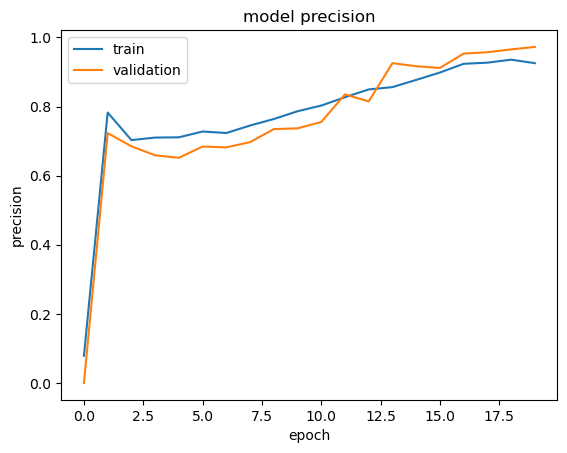

In [9]:
from matplotlib import pyplot as plt
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
from sklearn import metrics as mt
yhat = np.round(model1.predict([X_test_crossed,X_test_cat,X_test_num])).astype(int)
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))
unique_yhat, counts_yhat = np.unique(yhat, return_counts=True)
print("Y hat\n",np.asarray((unique_yhat, counts_yhat)).T)
unique_ytest, counts_ytest = np.unique(y_test, return_counts=True)
print("actual\n",np.asarray((unique_ytest, counts_ytest)).T)

305/305 [==============================] - 1s 2ms/step
[[8874    7]
 [ 603  248]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8881
           1       0.97      0.29      0.45       851

    accuracy                           0.94      9732
   macro avg       0.95      0.65      0.71      9732
weighted avg       0.94      0.94      0.92      9732

Y hat
 [[   0 9477]
 [   1  255]]
actual
 [[   0 8881]
 [   1  851]]


#### 2.2 Investigate Performance by Altering the Number of Layers in the Deep Branch of the Network

Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly.

In [11]:
# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):

    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1


    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)

    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col+'_embed')(x)

    # save these outputs to concatenate later
    crossed_outputs.append(x)

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):

    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_train[col].max()+1

    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)

    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col+'_embed')(x)

    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)

# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)

all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
# 5 layers now
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=40,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=30,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=20,activation='relu', name='deep4')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep5')(deep_branch)

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model2 = Model(inputs=[input_crossed,input_cat,input_num],
              outputs=final_branch)

model2.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.Precision()])

history = model2.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train,
                    epochs=20,
                    batch_size=10,
                    verbose=1,
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/20
3893/3893 [==============================] - 24s 5ms/step - loss: 0.0901 - precision_1: 0.1138 - val_loss: 0.0786 - val_precision_1: 0.0000e+00
Epoch 2/20
3893/3893 [==============================] - 24s 6ms/step - loss: 0.0762 - precision_1: 0.0000e+00 - val_loss: 0.0753 - val_precision_1: 0.0000e+00
Epoch 3/20
3893/3893 [==============================] - 18s 5ms/step - loss: 0.0740 - precision_1: 0.0000e+00 - val_loss: 0.0739 - val_precision_1: 0.6667
Epoch 4/20
3893/3893 [==============================] - 15s 4ms/step - loss: 0.0724 - precision_1: 0.7127 - val_loss: 0.0727 - val_precision_1: 0.6667
Epoch 5/20
3893/3893 [==============================] - 13s 3ms/step - loss: 0.0713 - precision_1: 0.7212 - val_loss: 0.0725 - val_precision_1: 0.7288
Epoch 6/20
3893/3893 [==============================] - 16s 4ms/step - loss: 0.0705 - precision_1: 0.7310 - val_loss: 0.0717 - val_precision_1: 0.7463
Epoch 7/20
3893/3893 [==============================] - 12s 3ms/step - loss: 0

In [ ]:
yhat = np.round(model2.predict([X_test_crossed,X_test_cat,X_test_num])).astype(int)
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))
unique_yhat, counts_yhat = np.unique(yhat, return_counts=True)
print("Y hat\n",np.asarray((unique_yhat, counts_yhat)).T)
unique_ytest, counts_ytest = np.unique(y_test, return_counts=True)
print("actual\n",np.asarray((unique_ytest, counts_ytest)).T)

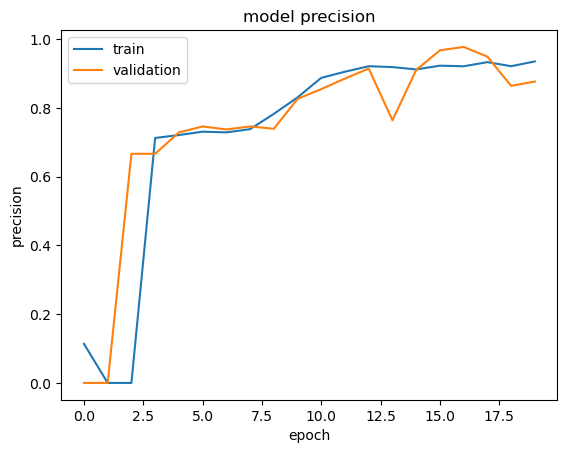

In [12]:
plt.plot(history.history['precision_1'])
plt.plot(history.history['val_precision_1'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### 2.3 Third wide and deep network

In [13]:
# # get new crossed columns
# cross_columns = [
#     ['department','education'],
#     ['recruitment_channel','education'],
#     ['department', 'region'],
#     ['department', 'education', 'region']
# ]
# cross_col_df_names = []
# for cols_list in cross_columns:
#     # encode as ints for the embedding
#     enc = LabelEncoder()
#     # 1. create crossed labels by join operation
#     X_crossed_train = df_train[cols_list].apply(lambda x: '_'.join(x), axis=1)
#     X_crossed_test = df_test[cols_list].apply(lambda x: '_'.join(x), axis=1)
#
#     # get a nice name for this new crossed column
#     cross_col_name = '_'.join(cols_list)
#
#     # 2. encode as integers, stacking all possibilities
#     enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
#
#     # 3. Save into dataframe with new name
#     df_train[cross_col_name] = enc.transform(X_crossed_train)
#     df_test[cross_col_name] = enc.transform(X_crossed_test)
#
#     # keep track of the new names of the crossed columns
#     cross_col_df_names.append(cross_col_name)
#
# cross_col_df_names

In [14]:
crossed_outputs = []
# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):

    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1


    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)

    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col+'_embed')(x)

    # save these outputs to concatenate later
    crossed_outputs.append(x)

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):

    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1

    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)

    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col+'_embed')(x)

    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)

# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)

all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
# 7 layers now
deep_branch = Dense(units=30,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=20,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=5,activation='relu', name='deep4')(deep_branch)

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model3 = Model(inputs=[input_crossed,input_cat,input_num],
              outputs=final_branch)

model3.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.Precision()])

history = model3.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train,
                    epochs=20,
                    batch_size=10,
                    verbose=1,
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/20
3893/3893 [==============================] - 23s 5ms/step - loss: 0.0956 - precision_2: 0.0733 - val_loss: 0.0779 - val_precision_2: 0.0000e+00
Epoch 2/20
3893/3893 [==============================] - 24s 6ms/step - loss: 0.0764 - precision_2: 0.0000e+00 - val_loss: 0.0763 - val_precision_2: 0.0000e+00
Epoch 3/20
3893/3893 [==============================] - 23s 6ms/step - loss: 0.0751 - precision_2: 0.0000e+00 - val_loss: 0.0751 - val_precision_2: 0.0000e+00
Epoch 4/20
3893/3893 [==============================] - 23s 6ms/step - loss: 0.0739 - precision_2: 0.0000e+00 - val_loss: 0.0740 - val_precision_2: 0.0000e+00
Epoch 5/20
3893/3893 [==============================] - 19s 5ms/step - loss: 0.0724 - precision_2: 1.0000 - val_loss: 0.0724 - val_precision_2: 1.0000
Epoch 6/20
3893/3893 [==============================] - 21s 5ms/step - loss: 0.0709 - precision_2: 0.7857 - val_loss: 0.0716 - val_precision_2: 0.6630
Epoch 7/20
3893/3893 [==============================] - 19s 5ms/st

In [ ]:
yhat = np.round(model3.predict([X_test_crossed,X_test_cat,X_test_num])).astype(int)
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))
unique_yhat, counts_yhat = np.unique(yhat, return_counts=True)
print("Y hat\n",np.asarray((unique_yhat, counts_yhat)).T)
unique_ytest, counts_ytest = np.unique(y_test, return_counts=True)
print("actual\n",np.asarray((unique_ytest, counts_ytest)).T)

 935/3893 [======>.......................] - ETA: 10s - loss: 0.0679 - precision_2: 0.6989

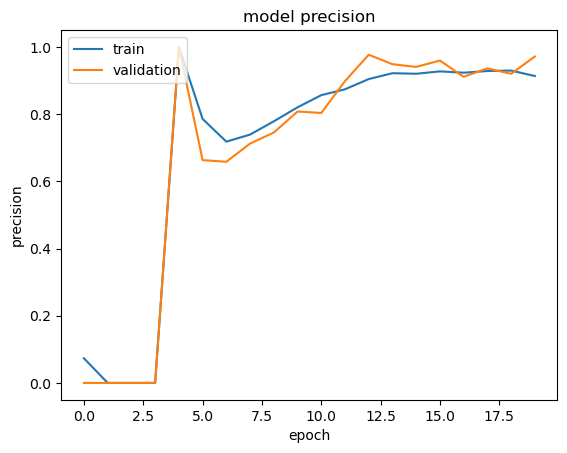

In [15]:
plt.plot(history.history['precision_2'])
plt.plot(history.history['val_precision_2'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### 2.4 Investigate Performance of the Best Wide and Deep Network to Multi-Layer Perceptron

Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). Alternatively, you can compare to a network without the wide branch (i.e., just the deep network). For classification tasks, compare using the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical methods to compare the performance of different models.  

In [16]:
# Now let's define the architecture for a multi-layer network

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):

    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1

    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)

    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col+'_embed')(x)

    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)

# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)

all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
# 7 layers now

deep_branch = Dense(units=30,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=20,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=5,activation='relu', name='deep4')(deep_branch)

# merge the deep and wide branch
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(deep_branch)

MLPModel = Model(inputs=[input_cat,input_num],
              outputs=final_branch)
MLPModel.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.Precision()])
history = MLPModel.fit([X_train_cat,X_train_num],
                    y_train,
                    epochs=20,
                    batch_size=10,
                    verbose=1,
                    validation_data = ([X_test_cat,X_test_num],y_test))



Epoch 1/20
3893/3893 [==============================] - 20s 5ms/step - loss: 0.1027 - precision_3: 0.0775 - val_loss: 0.0811 - val_precision_3: 0.0000e+00
Epoch 2/20
3893/3893 [==============================] - 18s 5ms/step - loss: 0.0785 - precision_3: 0.0000e+00 - val_loss: 0.0770 - val_precision_3: 0.0000e+00
Epoch 3/20
3893/3893 [==============================] - 18s 5ms/step - loss: 0.0750 - precision_3: 0.7306 - val_loss: 0.0743 - val_precision_3: 0.6782
Epoch 4/20
3893/3893 [==============================] - 19s 5ms/step - loss: 0.0728 - precision_3: 0.6889 - val_loss: 0.0728 - val_precision_3: 0.7143
Epoch 5/20
3893/3893 [==============================] - 17s 4ms/step - loss: 0.0714 - precision_3: 0.6883 - val_loss: 0.0722 - val_precision_3: 0.7500
Epoch 6/20
3893/3893 [==============================] - 17s 4ms/step - loss: 0.0708 - precision_3: 0.7128 - val_loss: 0.0719 - val_precision_3: 0.7432
Epoch 7/20
3893/3893 [==============================] - 17s 4ms/step - loss: 0.070

In [20]:
yhatMLP = np.round(MLPModel.predict([X_test_cat,X_test_num])).astype(int)
print(mt.confusion_matrix(y_test,yhatMLP))
print(mt.classification_report(y_test,yhatMLP))
unique_yhat, counts_yhat = np.unique(yhatMLP, return_counts=True)
print("Y hat\n",np.asarray((unique_yhat, counts_yhat)).T)
unique_ytest, counts_ytest = np.unique(y_test, return_counts=True)
print("actual\n",np.asarray((unique_ytest, counts_ytest)).T)

305/305 [==============================] - 2s 5ms/step
[[8868   13]
 [ 621  230]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      8881
           1       0.95      0.27      0.42       851

    accuracy                           0.93      9732
   macro avg       0.94      0.63      0.69      9732
weighted avg       0.94      0.93      0.92      9732

Y hat
 [[   0 9489]
 [   1  243]]
actual
 [[   0 8881]
 [   1  851]]


305/305 [==============================] - 1s 3ms/step


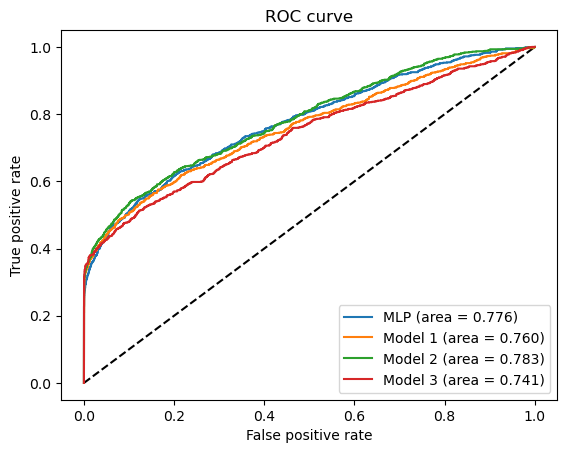

In [28]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
yhatMLP = MLPModel.predict([X_test_cat,X_test_num]).ravel()
fpr_mlp, tpr_mlp, thresholds_keras = roc_curve(y_test, yhatMLP)
auc_mlp = auc(fpr_mlp, tpr_mlp)
yhat_model1 = model1.predict([X_test_crossed,X_test_cat,X_test_num]).ravel()
fpr_model1, tpr_model1, thresholds_keras = roc_curve(y_test, yhat_model1)
auc_model1= auc(fpr_model1, tpr_model1)
yhat_model2 = model2.predict([X_test_crossed,X_test_cat,X_test_num]).ravel()
fpr_model2, tpr_model2, thresholds_keras = roc_curve(y_test, yhat_model2)
auc_model2= auc(fpr_model2, tpr_model2)
yhat_model3 = model3.predict([X_test_crossed,X_test_cat,X_test_num]).ravel()
fpr_model3, tpr_model3, thresholds_keras = roc_curve(y_test, yhat_model3)
auc_model3= auc(fpr_model3, tpr_model3)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))
plt.plot(fpr_model1, tpr_model1, label='Model 1 (area = {:.3f})'.format(auc_model1))
plt.plot(fpr_model2, tpr_model2, label='Model 2 (area = {:.3f})'.format(auc_model2))
plt.plot(fpr_model3, tpr_model3, label='Model 3 (area = {:.3f})'.format(auc_model3))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

    ### 3. Capturing the Embedding Weights from the Deep Network

Capture the embedding weights from the deep network and (if needed) perform dimensionality reduction on the output of these embedding layers (only if needed). That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data.

In [29]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 categorical_input (InputLayer)  [(None, 5)]         0           []                               
                                                                                                  
 tf.compat.v1.gather_19 (TFOpLa  (None,)             0           ['categorical_input[0][0]']      
 mbda)                                                                                            
                                                                                                  
 tf.compat.v1.gather_20 (TFOpLa  (None,)             0           ['categorical_input[0][0]']      
 mbda)                                                                                            
                                                                                            

In [ ]:
model3.get_layer()